In [1]:
import numpy as np
import pandas as pd
import os
import glob
import ml_metrics as metrics
import sys
from sklearn.metrics import f1_score, precision_score

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
# path = "/Users/kwonyoung-ju/Documents/tand/macaron/data/20180920-20180929_CF_data/"
path = "/Users/kwonyoung-ju/Documents/tand/macaron/paraquet/"
meta_path = "/Users/kwonyoung-ju/Documents/tand/macaron/"

In [ ]:
# load model
model = KeyedVectors.load_word2vec_format('item_vectors.txt', binary=False)

## Read data

In [2]:
# read distributed file
allFiles = glob.glob(path + "train_data"+ "/*.csv")
list_=[]
train = pd.DataFrame()
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
train = pd.concat(list_)

allFiles = glob.glob(path + "test_data"+ "/*.csv")
list_=[]
test = pd.DataFrame()
for file_ in allFiles:
    df = pd.read_csv(file_,index_col=None, header=0)
    list_.append(df)
test = pd.concat(list_)

# train = pd.read_csv( path+"train_data.csv")
# test = pd.read_csv( path+"test_data.csv")
data =pd.concat([train, test])

In [3]:
# read meta data
meta = pd.read_csv(meta_path+"2018-10-31_android.detail+developer.csv")

In [4]:
print(train.shape)
print(test.shape)

print(data.shape)
len(pd.unique(train.iloc[:, 3]))

(6676192, 5)
(88561, 5)
(6764753, 5)


52763

In [5]:
# unique app list
a= set(pd.unique(train.iloc[:,3]))
b =set(pd.unique(test.iloc[:,3]))
print("train length: "+str(len(a)))
print("test length: "+str(len(b)))
print("union: "+ str(len(set.union(a,b))))
print("intersection: "+ str(len(set.intersection(a,b))))
print("train - test: "+ str(len(a-b)))
print("test - train: "+ str(len(b-a)))

train length: 52763
test length: 11843
union: 53108
intersection: 11498
train - test: 41265
test - train: 345


## Process data

In [6]:
# app list for each adid
train_list = train.groupby("adid")["app_id"].apply(list)
test_list = test.groupby("adid")["app_id"].apply(list)

train_list.head()

adid
0000b754-6fcf-48e4-8507-6d14bd98f44b    [12, 6, 27, 201, 38, 14615, 47, 124093, 130, 1...
00023dcc-d109-4d2a-aa81-a7e286c949a9    [123648, 124493, 104, 3, 322, 123646, 123662, 14]
0002e6ec-d23f-4d63-988e-d4c63425f980    [88513, 123662, 126327, 19, 28, 21, 70, 96, 32...
00032fb8-9f2b-4f71-ba5b-6821a1a9bcb7    [2, 188, 4, 246, 6, 41840, 8, 124102, 37, 1241...
000340bd-cc98-41c8-b90c-880284b32996    [56, 152, 24, 51, 123938, 107, 139, 1, 556, 12...
Name: app_id, dtype: object

In [7]:
# integer app list to string
train_str_list = [[str(word) for word in word_list] for word_list in train_list]
test_str_list  = [[str(word) for word in word_list] for word_list in test_list]

print(len(train_str_list))
print(len(test_str_list))

93227
1719


In [8]:
# split test data into known and unknown
test_known = test[test.flag==0].groupby("adid")["app_id"].apply(list)
test_unknown = test[test.flag==1].groupby("adid")["app_id"].apply(list)
test_known_list = [[str(word) for word in word_list] for word_list in test_known]
test_unknown_list  = [[str(word) for word in word_list] for word_list in test_unknown]

## Train model

In [21]:
%%time
model = Word2Vec(train_str_list, size=200, window=1000, min_count=1, sg=1, negative = 15, ns_exponent=0.75, 
                workers =16, iter=12, alpha=0.04, seed=1)

CPU times: user 8h 58min 44s, sys: 1min 29s, total: 9h 14s
Wall time: 1h 10min 21s


In [10]:
# save model
model.wv.save_word2vec_format('item_vectors_12iter.txt')

## Accuracy

In [11]:
# Retrieve different elements between two lists
def Diff(li1, li2): 
    diff=set(li1)-set(li2)
    result = [o for o in li1 if o in diff]
    return result 

In [12]:
# F1 score
def cal_F1(i,k):

    actual = test_unknown_list[i]
    known = test_known_list[i]
    pred_list = list(list(zip(*pred[i]))[0])
    predicted = Diff(pred_list, known)[:k]
    
    tp =len(set(actual).intersection(set(predicted)))
    tpfn = len(set(actual))
    tpfp = len(set(predicted))

    precision = tp / tpfp
    recall = tp / tpfn
    if(precision==0 or recall==0):
        F1 =0
    else:
        F1 = 2*precision*recall/(precision+recall)
    return [F1, precision, recall]

In [22]:
# MAP@k
# app data discrepancy between train and test set
train_unique_set=set(pd.unique(train.iloc[:,3]).astype(str))

n = len(test_unknown_list)
result = [None]*n
known_list = list(map(train_unique_set.intersection, test_known_list))
known_list = [[*element] for element in known_list]

# get mean value of embeddings
mean_val_list = [np.mean(list(map(model.wv.word_vec, known_element)),0) for known_element in known_list]
# 300 predict list
pred = list(map( lambda x: model.wv.similar_by_vector(x, 300), mean_val_list))
# exclude similarity
pred_list = [list(zip(*pred_list))[0] for pred_list in pred]
# difference between known data and predicted
predicted_list = list(map(lambda i: Diff(pred_list[i], known_list[i]), np.arange(n)))

result =metrics.mapk(test_unknown_list, predicted_list, 10)
print("map@10: "+ str(np.mean(result)))
result = metrics.mapk(test_unknown_list, predicted_list, 30)
print("map@30: "+ str(np.mean(result)))
result = metrics.mapk(test_unknown_list, predicted_list, 50)
print("map@50: "+ str(np.mean(result)))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/gensim/matutils.py:737: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(vec.dtype, np.int):


map@10: 0.034542050256855375
map@30: 0.03815776556979286
map@50: 0.03989884235167276


In [23]:
# F1@k
# get mean value of embeddings\

result = list(map(lambda i: cal_F1(i, 10), np.arange(n)  ))
print("F1@10: "+ str(np.mean(np.array(result),0)))
result = list(map(lambda i: cal_F1(i, 30), np.arange(n)  ))
print("F1@30: "+ str(np.mean(np.array(result),0)))
result = list(map(lambda i: cal_F1(i, 50), np.arange(n)  ))
print("F1@50: "+ str(np.mean(np.array(result),0)))

F1@10: [0.03463395 0.03007563 0.07976881]
F1@30: [0.03109067 0.02072911 0.15870742]
F1@50: [0.02717464 0.01673066 0.20958192]


In [300]:
i=9
k=50
actual = test_unknown_list[i]
known = test_known_list[i]
pred_list = list(list(zip(*pred[i]))[0])
predicted = Diff(pred_list, known)[:k]
print(actual)
print(predicted)
metrics.apk(actual, predicted,k)

['127868']
['1908', '2045', '124171', '48033', '9033', '5590', '4170', '2138', '67818', '123959', '83206', '9168', '1379', '16454', '124388', '123641', '51154', '43412', '124422', '123994', '124511', '102079', '2093', '120042', '41975', '125438', '124980', '103641', '1021', '125018', '49668', '14347', '10575', '98102', '3052', '124983', '123589', '125432', '6812', '125177', '697', '22872', '110516', '1576', '81494', '111348', '124959', '1575', '16358', '102598']


0.0

In [302]:
# similarity check
# 322 macaron
j=322

vocab = model.wv.vocab
vocab_df = pd.DataFrame({'app_key': vocab})
vocab_title = pd.merge(vocab_df, meta, on="app_key", how="left")
print(vocab_title.query("app_key=="+str(j))["appTitle"])
id_temp = pd.DataFrame.transpose(pd.DataFrame(list(zip(*model.wv.similar_by_vector(X[j], 30)))))
id_temp.columns=['app_key', 'similairty']
id_temp.app_key= id_temp.app_key.astype(int)
id_temp.merge(vocab_title).loc[:, ['app_key', 'appTitle', 'similairty']]
#type(vocab_title.app_key[0])
# print(list(map(lambda x: vocab_title.query("app_key=="+id_temp[x])["appTitle"], np.arange(30))))

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:5: DeprecationWarning: Call to deprecated `wv` (Attribute will be removed in 4.0.0, use self instead).
  """


ValueError: You are trying to merge on object and int64 columns. If you wish to proceed you should use pd.concat

In [20]:
# prediction check
i= 100
actual = test_unknown_list[i]
known = test_known_list[i]
pred_list = list(list(zip(*pred[i]))[0])
predicted = Diff(pred_list, known)[:n]

print(vocab_title[vocab_title['app_key'].isin(test_known_list[i])]["appTitle"])
# print(vocab_title[vocab_title['app_key'].isin(actual)]["appTitle"])
print(vocab_title[vocab_title['app_key'].isin(predicted)]["appTitle"])

8                                    마카롱캠 - 동영상촬영/무음/사진편집기
59                                               Instagram
201                                     WhatsApp Messenger
206                                                Hotstar
207      ShareChat - WhatsApp Status, Videos, Shayari, ...
208                             SHAREit - Transfer & Share
211                                                    NaN
215                          TikTok - including musical.ly
219                                                MX 플레이어
1018                            플래쉬라이트 - Tiny Flashlight ®
9694                         Voot TV Shows Movies Cartoons
9945                        Wynk Music: Songs, Radio & MP3
17266                                    My Photo Keyboard
Name: appTitle, dtype: object
196      VidStatus app - Status Videos & Status Downloader
199                                    UC Browser - UC브라우저
200                           Amazon India Online Shopping
202            이모지 키보드 Fac

## Visualize

In [18]:
from sklearn.manifold import TSNE
import matplotlib as mpl
import matplotlib.pyplot as plt
from matplotlib import font_manager, rc
import platform

In [16]:
def tsne_viz(vocab, n=list(range(0,100)), title=True):
    vocab = list(vocab)
    X = model[vocab]

    vocab_df = pd.DataFrame({'app_key': vocab})
    vocab_df['app_key'] = vocab_df['app_key'].astype(int)
    vocab_title = pd.merge(vocab_df, meta, on="app_key", how="left")
    tsne = TSNE(n_components=2)

    # n개의 단어에 대해서만 시각화
    X_tsne = tsne.fit_transform(X[n,:])
    
    # font settting
    rc('font', family="AppleGothic")
    # r: par(family="AppleGothic")

    df = pd.DataFrame(X_tsne, index=vocab_title.iloc[n, 6], columns=['x', 'y'])

    fig = plt.figure()
    fig.set_size_inches(20, 20)
    ax = fig.add_subplot(1, 1, 1)

    # print with title
    if(title):
        ax.scatter(df['x'], df['y'], c=vocab_title.iloc[n, 3], s=150)

        for word, pos in df.iterrows():
            ax.annotate(word, pos, fontsize=25)
        plt.show()
        
    else:
        ax.scatter(X_tsne[:,0], X_tsne[:,1], c=vocab_title.iloc[n, 3], s=150, label=vocab_title.iloc[n,5])
        plt.show()
    
    return df

/Library/Frameworks/Python.framework/Versions/3.7/lib/python3.7/site-packages/ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until


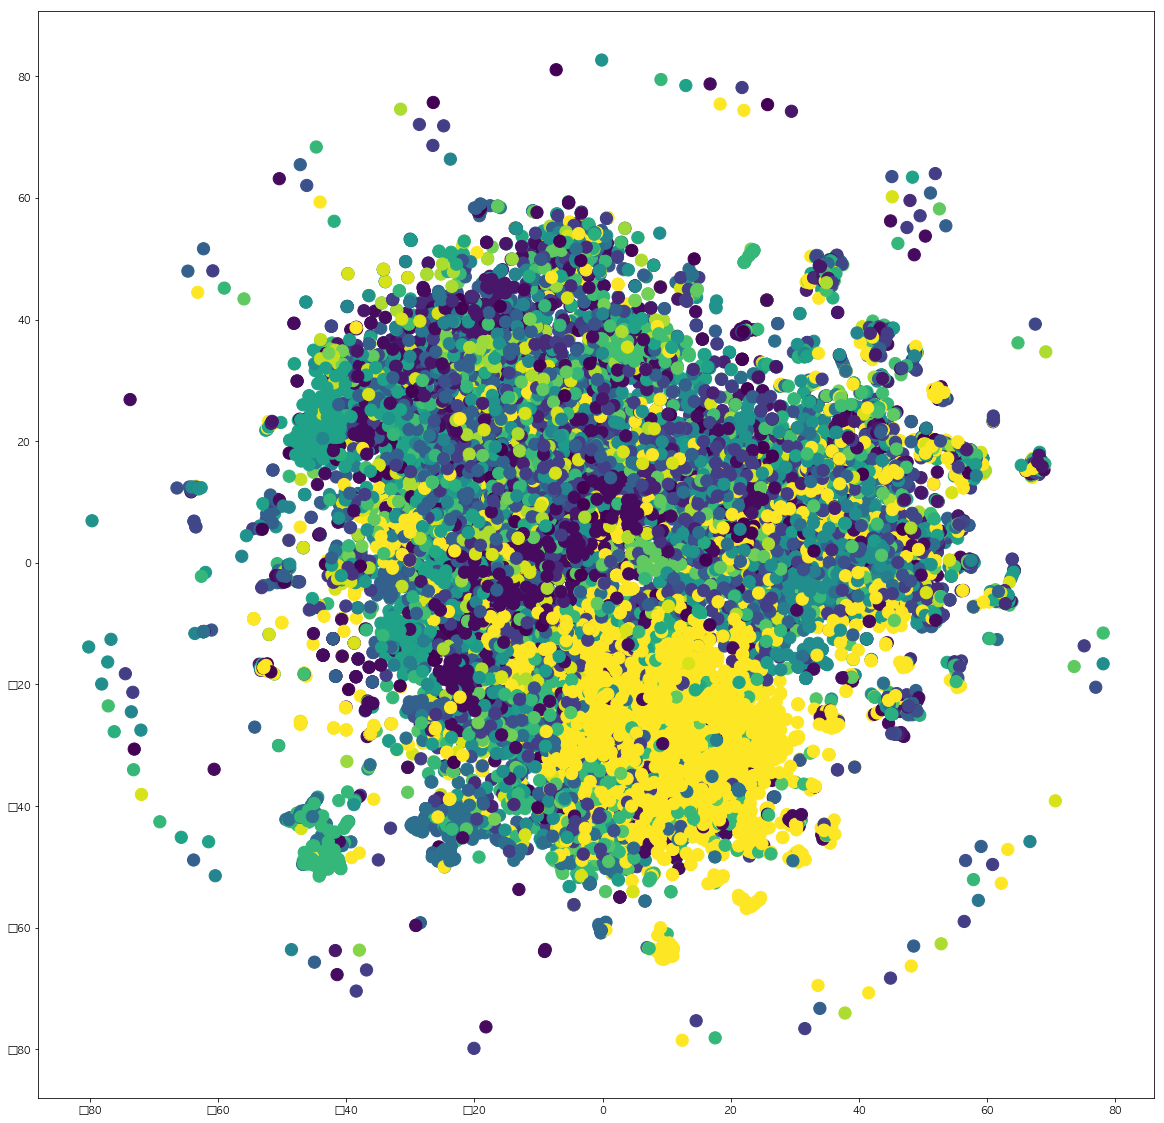

In [20]:
df = tsne_viz(model.wv.vocab, list(range(0, 10000)), False) #len(model.wv.vocab)

## Buffer

## Tuning

## hs
em size: 50
0.011927484624470075
em size: 100
0.01198868863667579
em size: 200
0.011993800568525314
em size: 300
0.011622682323804015
em size: 400
0.011658429410742324

em size: 20, negative:1, ns_exponent:0.7
0.010383110308884601
em size: 20, negative:1, ns_exponent:0.8
0.010437442326050992
em size: 20, negative:1, ns_exponent:0.9
0.0076653750184777
em size: 20, negative:2, ns_exponent:0.7
0.010498047901510887
em size: 20, negative:2, ns_exponent:0.8
0.010742755783333885
em size: 20, negative:2, ns_exponent:0.9
0.012437247435804967
em size: 50, negative:1, ns_exponent:0.7
0.010666668192136047
em size: 50, negative:1, ns_exponent:0.8
0.009240447217096904
em size: 50, negative:1, ns_exponent:0.9
0.00968484301536903
em size: 50, negative:2, ns_exponent:0.7
0.011831203167071641
em size: 50, negative:2, ns_exponent:0.8
0.011770788899093483
em size: 50, negative:2, ns_exponent:0.9
0.011120396533034427
em size: 100, negative:1, ns_exponent:0.7
0.010151080359261207
em size: 100, negative:1, ns_exponent:0.8
0.008838179331327788
em size: 100, negative:1, ns_exponent:0.9
0.00854105353536785
em size: 100, negative:2, ns_exponent:0.7
0.011940241456784278
em size: 100, negative:2, ns_exponent:0.8
0.010781907007148721
em size: 100, negative:2, ns_exponent:0.9
0.011153993918198327